# Paired integration

```{dropdown} <i class="fas fa-brain"></i>&nbsp;&nbsp;&nbsp;Key takeaways

:::{card}
:link: multimodal-integration-paired-integration-key-takeaway-1
:link-type: ref
The integration of single-cell multi-modal data (e.g., gene expression and chromatin accessibility) is challenging due to differences in dimensionality and data distributions across modalities, but tools like MOFA+, WNN, totalVI, and multiVI aim to address these challenges.
:::

:::{card}
:link: multimodal-integration-paired-integration-key-takeaway-2
:link-type: ref
Query-to-reference mapping allows for the integration of new data into a pre-existing reference framework, enabling tasks like cell type prediction and imputation of missing modalities (e.g., predicting protein abundance from RNA-seq data)
:::

```

<!-- START ENV-SETUP -->
<!-- END ENV-SETUP -->

(multimodal-integration-paired-integration-key-takeaway-1)=
## Motivation

In the recent years several technologies appeared that allow us to measure several modalities in a single-cell. Modalities in this context refer to different type of information that we can capture in each cell. For instance, CITE-seq allows measuring gene expression and surface protein abundance in the same cell. Alternatively, paired RNA-seq/ATAC-seq experiments using, for example, the Multiome assay, capture gene expression and chromatin accessibility simultaneously. 

We are interested in the most holistic representation of single cells that incorporate information from all the available modalities, but several challenges might arise when integrating these different modalities. Data stemming from different sequencing technologies can vary in dimensions: RNA-seq experiments usually capture 20-30 thousand genes, but the protein panel can be as small just a few proteins up to 200. ATAC-seq experiments on the other hand can have more than 200000 peaks. On top of having different dimensionality, the data can follow different distributions. RNA-seq counts are often modelled with negative binomial distribution, while chromatin accessibility can be binarized and modelled as either open or closed and therefore with a Bernoulli distribution {cite}`pi:ashuach2021`. Alternatively raw ATAC-seq counts can be modelled following Poisson distribution {cite}`pi:martens2022`.

Here, we showcase several tools for paired integration including MOFA+ {cite}`pi:argelaguet2020`, WNN {cite}`pi:hao2021`, totalVI {cite}`pi:gayoso2021` and multiVI {cite}`pi:ashuach2021`. We use 10x Multiome and CITE-seq data generated for the single cell data integration challenge at the NeurIPS conference 2021 {cite}`pi:luecken2021sandbox`. This dataset captures single-cell data from bone marrow mononuclear cells of 12 healthy human donors measured at four different sites to obtain nested batch effects. In this tutorial, we will use 3 batches from one site to showcase the integration tools. 

Since there are multiple integration tools available, it can be quite challenging to assess which tool to use for a particular task at hand. We therefore use the scIB {cite}`pi:luecken2022` package that allows to make such a decision by quantitatively assessing the quality of the integration. It is important to note though that scIB was designed for unimodal integration of batches and not for multimodal integration. We expect more metrics to appear in the near future that are specifically designed for multimodal data, but for now we show how to use scIB metrics to compare the integration results.

## Environment setup

In [1]:
import logging

import anndata as ad
import anndata2ri
import matplotlib.pyplot as plt
import muon as mu
import pandas as pd
import rpy2.rinterface_lib.callbacks
import scanpy as sc
import scib
import scipy
import scipy.io
import scvi
import seaborn as sns
from rpy2.robjects import pandas2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

import warnings

warnings.filterwarnings("ignore")

During startup - Warning message:
Setting LC_CTYPE failed, using "C" 
Global seed set to 0
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/paired_integration_chapter/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/paired_integration_chapter/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/lustre/groups/ml01/workspace/anastasia.li

In [2]:
%%R
suppressPackageStartupMessages({
    library(Seurat)
})
set.seed(123)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

## CITE-seq data

We first show how to integrate a CITE-seq dataset using WNN, MOFA+ and totalVI. CITE-seq data contains raw gene expression counts and counts for surface proteins. The surface protein data is represented as antibody-derived tags (adt) here. We refer to the {ref}`surface-protein:motivation` section of the Surface Proteins chapter for more details.

### Prepare data

In [3]:
adt = sc.read(
    "/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/neurips-cite/adt_pp.h5ad"
)
adt

AnnData object with n_obs × n_vars = 120502 × 136
    obs: 'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'outliers'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'batch_colors', 'donor_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_isotypes', 'X_pca', 'X_pcahm', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
rna = sc.read(
    "/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/neurips-cite/rna_hvg.h5ad"
)
rna

AnnData object with n_obs × n_vars = 90261 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'hvg', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

We subset the data to Site 1 and the 3 corresponding donors to reduce the run time.

In [5]:
batches_to_keep = ["s1d1", "s1d2", "s1d3"]
rna = rna[rna.obs["batch"].isin(batches_to_keep)]
adt = adt[adt.obs["donor"].isin(batches_to_keep)]

We only keep the cells that are present in both modality objects. First we need to make sure that `.obs_names` of both objects have similar structure and if not clean up a bit.

In [6]:
adt.obs_names

Index(['AAACCCAAGGATGGCT-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCAAGGCCTAGA-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCAAGTGAGTGC-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCACAAGAGGCT-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCACATCGTGGC-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCACATTCTCTA-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCAGTCCGCAGT-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCAGTGCATACT-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCAGTTGACGGA-1-0-0-0-0-0-0-0-0-0-0-0',
       'AAACCCATCGATACTG-1-0-0-0-0-0-0-0-0-0-0-0',
       ...
       'TTTGGTTCATGTTACG-1-1-0-0-0', 'TTTGGTTGTCTCACAA-1-1-0-0-0',
       'TTTGGTTTCCCATTCG-1-1-0-0-0', 'TTTGGTTTCCGTCCTA-1-1-0-0-0',
       'TTTGGTTTCTTGCGCT-1-1-0-0-0', 'TTTGTTGAGAGTCTGG-1-1-0-0-0',
       'TTTGTTGCAGACAATA-1-1-0-0-0', 'TTTGTTGCATGTTACG-1-1-0-0-0',
       'TTTGTTGGTAGTCACT-1-1-0-0-0', 'TTTGTTGTCGCGCTGA-1-1-0-0-0'],
      dtype='object', length=24326)

In [7]:
rna.obs_names

Index(['GCATTAGCATAAGCGG-1-s1d1', 'TACAGGTGTTAGAGTA-1-s1d1',
       'AGGATCTAGGTCTACT-1-s1d1', 'GTAGAAAGTGACACAG-1-s1d1',
       'TCCGAAAAGGATCATA-1-s1d1', 'CTCCCAATCCATTGGA-1-s1d1',
       'GACCAATCAATTTCGG-1-s1d1', 'TTCCGGTAGTTGTAAG-1-s1d1',
       'ACCTGTCAGGACTGGT-1-s1d1', 'TTCGATTTCAGGACAG-1-s1d1',
       ...
       'GTGGTTAGTCGAGTTT-1-s1d3', 'TGAGACTCAATAGTAG-1-s1d3',
       'CATGAGTTCAGCAGAG-1-s1d3', 'GCTACAACAGTGCGCT-1-s1d3',
       'AGAAATGAGTGCCTCG-1-s1d3', 'AACAAAGGTTGGTACT-1-s1d3',
       'TGACAGTCATGGCTGC-1-s1d3', 'CTGGCAGGTCTCACGG-1-s1d3',
       'GTAACCATCGGAGTGA-1-s1d3', 'GAGTTGTCAGTCGGAA-1-s1d3'],
      dtype='object', length=16311)

In [8]:
adt.obs_names = [
    name.split("-")[0] + "-" + name.split("-")[1] + "-" + batch
    for batch, name in zip(adt.obs["donor"], adt.obs_names)
]

In [9]:
common_idx = list(set(rna.obs_names).intersection(set(adt.obs_names)))
rna = rna[common_idx].copy()
adt = adt[common_idx].copy()

We need to rename the proteins in the `adt` object so that the gene names and protein names do not intersect.

In [10]:
adt.var_names = ["PROT_" + name for name in adt.var_names]

Next we create a MuData object where we store data for both modalities.

In [11]:
mdata = mu.MuData({"rna": rna, "adt": adt})
mdata

MuData object with n_obs × n_vars = 16294 × 4136
  var:	'feature_types'
  2 modalities
    rna:	16294 x 4000
      obs:	'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
      var:	'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'dataset_id', 'genome', 'hvg', 'organism'
      obsm:	'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
      layers:	'counts'
    adt:	16294 x 136
      obs:	'donor', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'outliers'
      var:	'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'batch_colors', 'donor_colors', 'neighbors', 'pca', 'umap'
      obsm:	'X_isotypes', 'X_pca', 'X_pcahm', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'

We copy `batch` and `cell_type` column from one of the modality adatas to `.obs` of the mdata object to later use for visualizations.

In [12]:
mdata.obs["batch"] = rna.obs["batch"].copy()
mdata.obs["cell_type"] = rna.obs["cell_type"].copy()

### Weighted Nearest Neighbor (WNN)

WNN is a graph-based method that takes neighbor graphs for each modality and constructs a common graph which is a weighted combination of the modality graphs. This constructed WNN graph can later be used together with gene expression matrix to obtain a supervised PCA (sPCA) representation guided by a WNN graph. The sPCA representation can be viewed as an embedding in a latent space.

First, we use the `anndata2ri` package (https://github.com/theislab/anndata2ri) to move Python AnnData object to SingleCellExperiment and Seurat R objects. We create slimmer versions of AnnData objects that only contain the information that we need to the analysis.

In [13]:
adata_ = ad.AnnData(adt.X.copy())
adata_.obs_names = adt.obs_names.copy()
adata_.var_names = adt.var_names.copy()
adata_.obs["batch"] = adt.obs["donor"].copy()
adata_.obsm["harmony_pca"] = adt.obsm["X_pcahm"].copy()

In [14]:
%%R -i adata_
# indicate that data is stored in .X of AnnData object
adt = as.Seurat(adata_, data='X', counts=NULL)
# the assay is called "originalexp" by default, we rename it to "ADT"
adt <- RenameAssays(object = adt, originalexp = "ADT", verbose=FALSE) 
adt

An object of class Seurat 
136 features across 16294 samples within 1 assay 
Active assay: ADT (136 features, 0 variable features)
 1 dimensional reduction calculated: harmony_pca


We repeat the same for RNA data.

In [15]:
adata_ = ad.AnnData(rna.X.copy())
adata_.obs_names = rna.obs_names.copy()
adata_.var_names = rna.var_names.copy()
adata_.obs["cell_type"] = rna.obs["cell_type"].copy()
adata_.obs["batch"] = rna.obs["batch"].copy()

In [16]:
%%R -i adata_
rna = as.Seurat(adata_, data='X', counts=NULL)
rna

An object of class Seurat 
4000 features across 16294 samples within 1 assay 
Active assay: originalexp (4000 features, 0 variable features)


Next we create a Seurat object with both assays.

In [17]:
%%R
cite <- rna
cite[["ADT"]] <- CreateAssayObject(data = adt@assays$ADT@data)

In [18]:
%%R
cite <- RenameAssays(object = cite, originalexp = "RNA", verbose=FALSE) 

Since we have several batches in the dataset, we would need to perform batch correction before integrating the modalities. One option would be to batch correct using Seurat's `FindIntegrationAnchors()` and `IntegrateData()` (see https://satijalab.org/seurat/articles/integration_introduction.html) functions separately for each modality. We will use batch corrected embedding from previous analysis done separately for ADT and RNA data, namely Harmony corrected PCA embedding for ADT and scVI batch-corrected latent embedding for RNA.

In [19]:
%%R
# TODO need to change after we have the preprocessed data, for now RNA is not batch-corrected
DefaultAssay(cite) <- "RNA"
VariableFeatures(cite) <- rownames(cite)
cite <- ScaleData(cite, verbose=FALSE)
cite <- RunPCA(cite, verbose=FALSE)

In [20]:
%%R
cite@reductions$harmony_pca <- adt@reductions$harmony_pca
cite

An object of class Seurat 
4136 features across 16294 samples within 2 assays 
Active assay: RNA (4000 features, 4000 variable features)
 1 other assay present: ADT
 2 dimensional reductions calculated: pca, harmony_pca


Now we follow the WNN vignette to perform the analysis. First, we need to find multimodal neighbors using the specified dimensionality reductions for each of the modalities. This function adds a WNN graph to the Seurat object.

In [21]:
%%R
cite <- FindMultiModalNeighbors(
    cite, 
    reduction.list = list("pca", "harmony_pca"), 
    dims.list = list(1:50, 1:30), 
    modality.weight.name = "RNA.weight",
    verbose = FALSE
)

Since we are also interested in finding an embedding for our multimodal data, we additionally run the `RunSPCA()` function that uses RNA gene expression data and the WNN graph for supervised PCA. Supervised PCA is a "guided" version of standard PCA run on gene expression data guided by the WNN graph to better preserve relationships between cells learn in WNN graph. We also will need a reference UMAP later for mapping an RNA query onto this multimodal reference as discussed in {ref}`multimodal-integration:advanced-integration`.

In [22]:
%%R
cite <- RunSPCA(cite, assay = "RNA", graph = "wsnn", npcs = 20)
cite <- RunUMAP(cite, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_", return.model=TRUE)

In [23]:
%%R
cite

An object of class Seurat 
4136 features across 16294 samples within 2 assays 
Active assay: RNA (4000 features, 4000 variable features)
 1 other assay present: ADT
 4 dimensional reductions calculated: pca, harmony_pca, spca, wnn.umap


We save the Seurat object as an `.rds` file for the {ref}`multimodal-integration:advanced-integration` section. 

In [24]:
%%R
saveRDS(cite, file = "wnn_ref.rds")

We move the sPCA embedding to Python and store them in `.obsm` of the MuData object.

In [25]:
%%R -o spca
spca = Embeddings(object = cite[["spca"]])

In [26]:
mdata.obsm["X_spca"] = spca

We also need to extract the calculated WNN graph.

In [27]:
%%R -o wnn
wnn <- as.data.frame(summary(cite@graphs$wknn))

The table indicates indices with connections between cells in the WNN graph. Since R starts indexing at 1 but Python at 0, we modify the indices to start with 0.

In [28]:
wnn[:5]

,i,j,x
1,1,1,1.0
2,202,1,1.0
3,787,1,1.0
4,1628,1,1.0
5,2076,1,1.0


In [29]:
wnn["i"] = wnn["i"] - 1
wnn["j"] = wnn["j"] - 1
wnn[:5]

,i,j,x
1,0,0,1.0
2,201,0,1.0
3,786,0,1.0
4,1627,0,1.0
5,2075,0,1.0


We store the graph in `.obsp` of the MuData object.

In [30]:
mdata.obsp["wnn_connectivities"] = scipy.sparse.coo_matrix(
    (wnn["x"], (wnn["i"], wnn["j"]))
)

Next we use the WWN graph to calculate the UMAP coordinates and save them in `.obsm['X_umap_wnn']`. We could alternatively also just use sPCA coordinates for visualization.

In [31]:
# we won't actually need the neighbors
# but need to run this anyway as a little trick to make scanpy work with externally-computed neighbors
sc.pp.neighbors(mdata, use_rep="X_spca")
mdata.obsp["connectivities"] = mdata.obsp["wnn_connectivities"].copy()
# delete distances to make sure we are not using anything calculated with sc.pp.neighbors()
del mdata.obsp["distances"]
sc.tl.umap(mdata)

In [32]:
mdata.obsm["X_umap_wnn"] = mdata.obsm["X_umap"].copy()

Finally we visualize the cell types and batches on a UMAP.

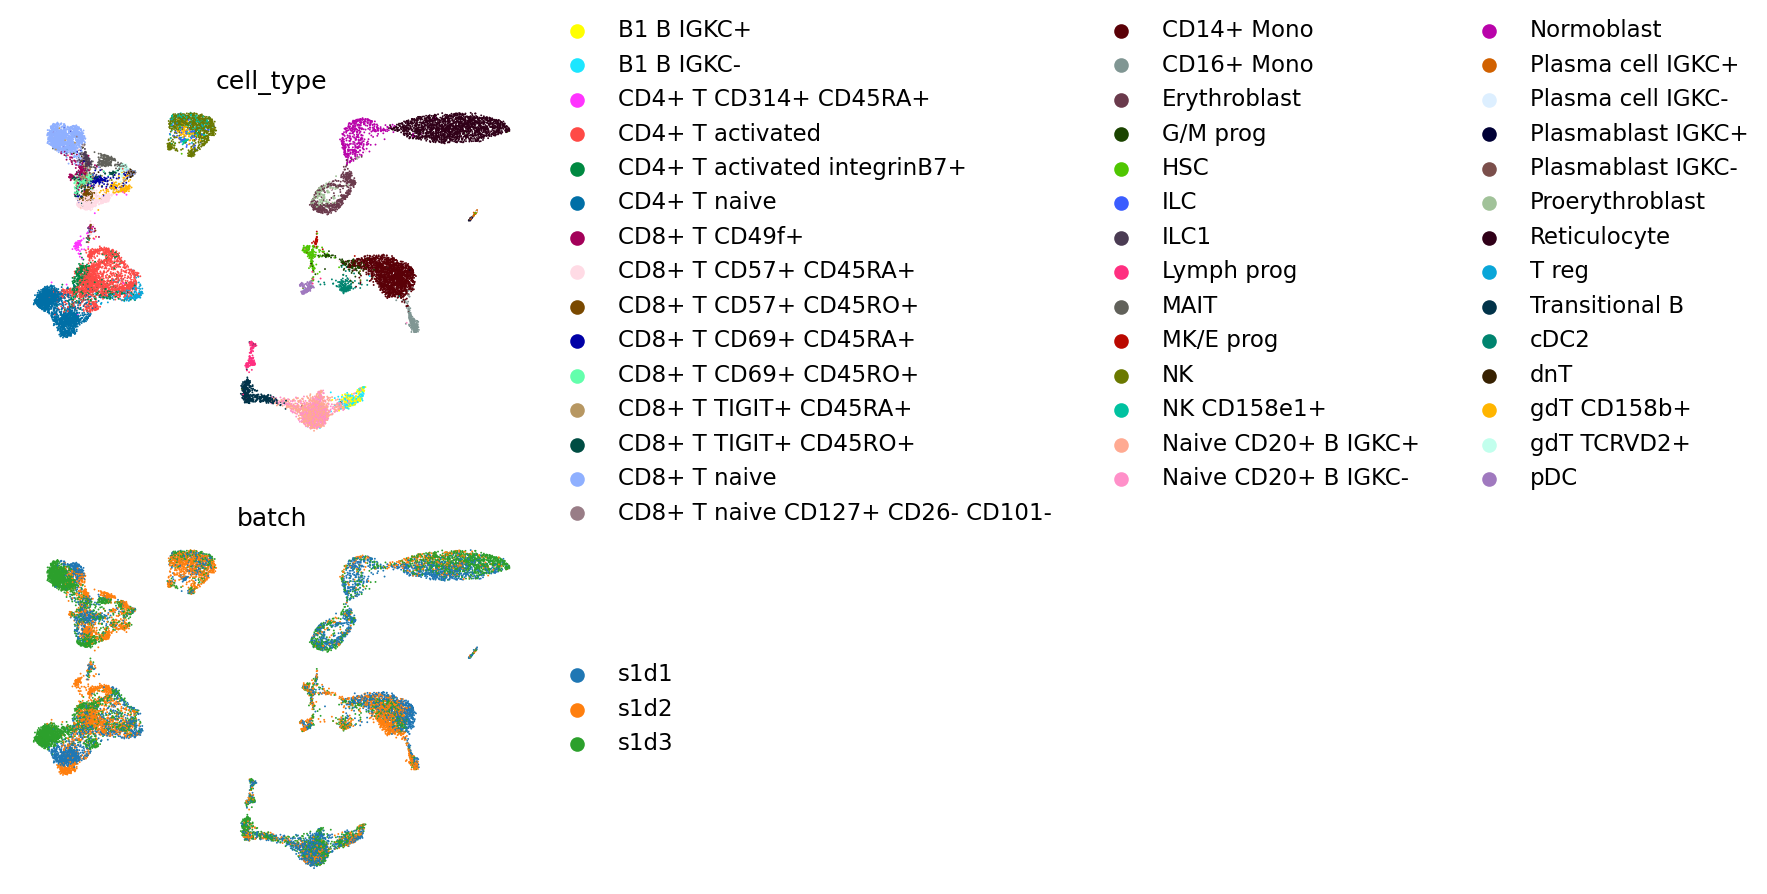

In [33]:
mu.pl.embedding(
    mdata, color=["cell_type", "batch"], ncols=1, basis="umap_wnn", frameon=False
)

To be able to quantitatively assess the result of the integration and compare to other methods we compute some of the scIB metrics using the sPCA embedding and WNN graph. More specifically, we calculate the following metrics:
- bio conservation: `NMI_cluster/label`, `ARI_cluster/label`, `ASW_label` and `isolated_label_silhouette`;
- batch correction: `ASW_label/batch`, `graph_conn`.

In [34]:
scib_anndata = sc.AnnData(mdata.obsm["X_spca"]).copy()
scib_anndata.obs = mdata.obs.copy()
scib_anndata.obsp["connectivities"] = mdata.obsp["connectivities"].copy()
scib_anndata.obsm["X_spca"] = mdata.obsm["X_spca"].copy()

In [35]:
metrics_wnn = scib.metrics.metrics(
    scib_anndata,
    scib_anndata,
    batch_key="batch",
    label_key="cell_type",
    embed="X_spca",
    ari_=True,
    nmi_=True,
    silhouette_=True,
    graph_conn_=True,
    isolated_labels_asw_=True,
)
metrics_wnn

NMI...
ARI...
Silhouette score...
Isolated labels ASW...
Graph connectivity...


,0
NMI_cluster/label,0.808672
ARI_cluster/label,0.729036
ASW_label,0.595822
ASW_label/batch,0.854867
PCR_batch,NaN
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,0.420527
graph_conn,0.914140
kBET,NaN


We note that even though batch correction was performed using Harmony for ADT and scVI for RNA, we still include metrics that assess batch correction here too.

### Multi-Omics Factor Analysis (MOFA+)

MOFA+ is a linear factor model that decomposes the input matrices into the product of low-rank matrices. The low-rank representation can be used as an embedding in a low-dimensional space for visualization and other downstream tasks. The latent dimensions are interpretable with respect to the original input features and represent the leading sources of variation in the data.

By default, we are using data from `.X` and the data should be normalized. Since there are some batch effects in the data that MOFA+ can correct for, we also pass the `groups_label` parameter to specify the batch covariate.

If you want to run MOFA+ on a GPU, you need to additionally install a version of cuPY (https://cupy.dev) which is compatible with your CUDA.

In [36]:
mu.tl.mofa(mdata, groups_label="batch", gpu_mode=True)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='rna' group='s1d1' with N=5219 samples and D=4000 features...
Loaded view='rna' group='s1d3' with N=4975 samples and D=4000 features...
Loaded view='rna' group='s1d2' with N=6100 samples and D=4000 features...
Loaded view='adt' group='s1d1' with N=5219 samples and D=136 features...
Loaded view='adt' group='s1d3' with N=4975 samples and D=136 features...
Loaded view='

We use the `X_mofa` representation to calculate the neighbors and the UMAP coordinates, and store them in `.obsm['X_umap_mofa']`.

In [37]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata)
mdata.obsm["X_umap_mofa"] = mdata.obsm["X_umap"].copy()

We plot the cell types and batches again on the resulting UMAP.

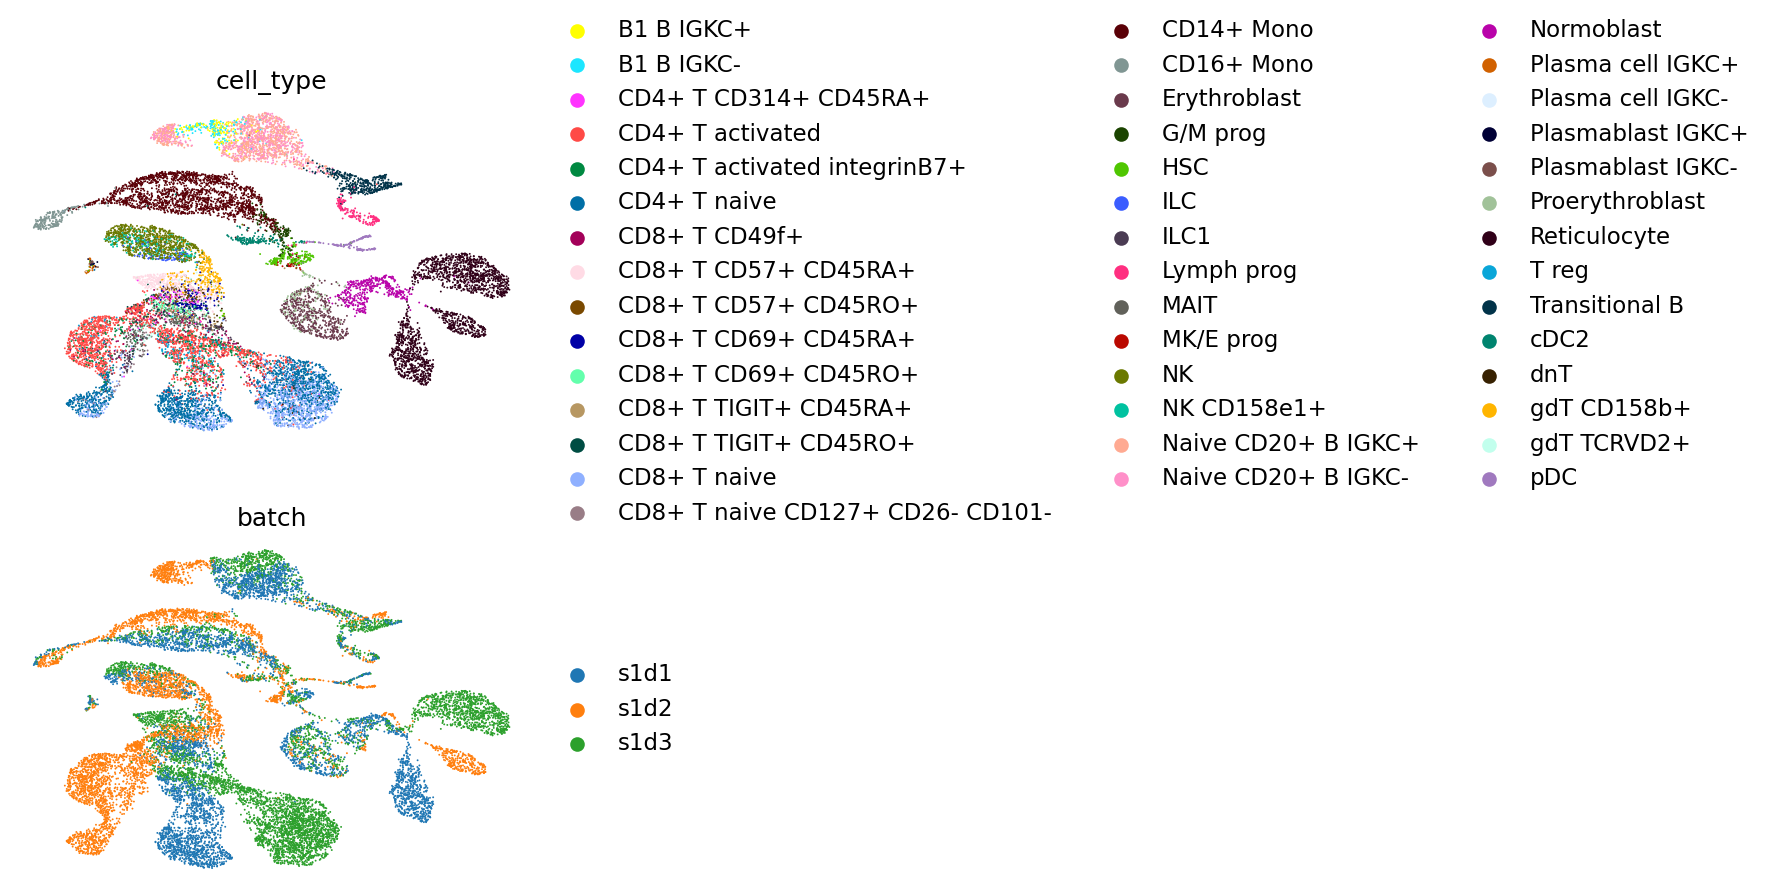

In [38]:
mu.pl.embedding(
    mdata, color=["cell_type", "batch"], ncols=1, basis="umap_mofa", frameon=False
)

Finally, we calculate the same scIB metrics as before.

In [39]:
scib_anndata = sc.AnnData(mdata.obsm["X_mofa"]).copy()
scib_anndata.obs = mdata.obs.copy()
scib_anndata.obsp["connectivities"] = mdata.obsp["connectivities"].copy()
scib_anndata.obsm["X_mofa"] = mdata.obsm["X_mofa"].copy()

In [40]:
metrics_mofa = scib.metrics.metrics(
    scib_anndata,
    scib_anndata,
    batch_key="batch",
    label_key="cell_type",
    embed="X_mofa",
    ari_=True,
    nmi_=True,
    silhouette_=True,
    graph_conn_=True,
    isolated_labels_asw_=True,
)
metrics_mofa

NMI...
ARI...
Silhouette score...
Isolated labels ASW...
Graph connectivity...


,0
NMI_cluster/label,0.727261
ARI_cluster/label,0.497166
ASW_label,0.566888
ASW_label/batch,0.800875
PCR_batch,NaN
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,0.418293
graph_conn,0.886662
kBET,NaN


### Total Variational Inference (totalVI)

TotalVI is variational-inference-based methods for joint analysis of paired gene expression and protein abundance measurements. It takes into account batch effects, protein background noise, which allows the model to learn a join latent representation disentangled form technical factors. TotalVI models transcriptome counts with negative-binomial (NB) distribution and the protein counts as NB mixture of foreground and background signal. Hence, the model takes raw gene expression and raw protein counts as input.

In [41]:
adata = mdata["rna"].copy()
adata.obsm["protein_expression"] = mdata["adt"].layers["counts"].A.copy()

We need to specify that raw counts for RNA are stored in `counts` layer of our adata and that we want to correct for batch effect with `batch_key="batch"` parameter.

In [42]:
scvi.model.TOTALVI.setup_anndata(
    adata,
    protein_expression_obsm_key="protein_expression",
    layer="counts",
    batch_key="batch",
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     Generating sequential column names                                                                        


We initialize the totalVI model.

In [43]:
vae = scvi.model.TOTALVI(adata)

INFO     Computing empirical prior initialization for protein background.                                          


Next, we train the model with default parameters.

In [44]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [09:22<00:00,  1.37s/it, loss=1.64e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [09:22<00:00,  1.41s/it, loss=1.64e+03, v_num=1]


Next, we obtain the latent representation and store it in `.obsm['X_totalVI']` and then use it to calculate the UMAP coordinates.

In [45]:
mdata.obsm["X_totalVI"] = vae.get_latent_representation()

In [46]:
sc.pp.neighbors(mdata, use_rep="X_totalVI")
sc.tl.umap(mdata)

In [47]:
mdata.obsm["X_umap_totalVI"] = mdata.obsm["X_umap"].copy()

As above, we plot cell types and batches on a UMAP.

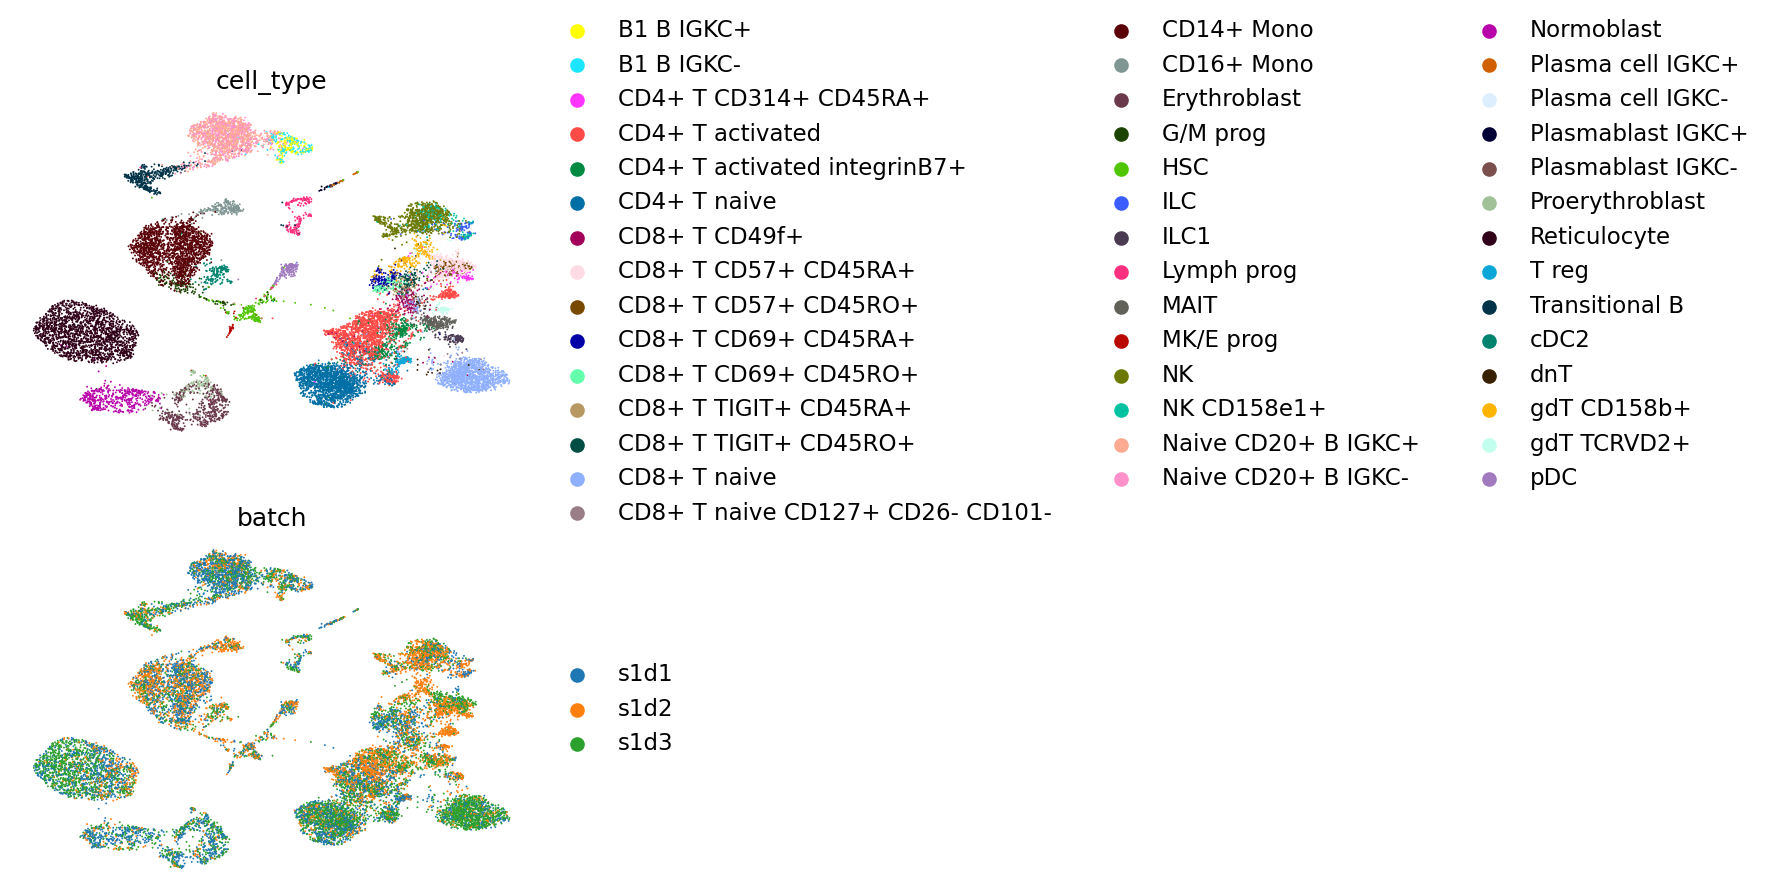

In [48]:
mu.pl.embedding(
    mdata, color=["cell_type", "batch"], ncols=1, basis="umap_totalVI", frameon=False
)

And finally, we calculate scIB metrics.

In [49]:
scib_anndata = sc.AnnData(mdata.obsm["X_totalVI"]).copy()
scib_anndata.obs = mdata.obs.copy()
scib_anndata.obsp["connectivities"] = mdata.obsp["connectivities"].copy()
scib_anndata.obsm["X_totalVI"] = mdata.obsm["X_totalVI"].copy()

In [50]:
metrics_totalvi = scib.metrics.metrics(
    scib_anndata,
    scib_anndata,
    batch_key="batch",
    label_key="cell_type",
    embed="X_totalVI",
    ari_=True,
    nmi_=True,
    silhouette_=True,
    graph_conn_=True,
    isolated_labels_asw_=True,
)
metrics_totalvi

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/paired_integration_chapter/lib/python3.9/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
Isolated labels ASW...
Graph connectivity...


,0
NMI_cluster/label,0.847325
ARI_cluster/label,0.796760
ASW_label,0.566315
ASW_label/batch,0.910679
PCR_batch,NaN
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,0.513436
graph_conn,0.959439
kBET,NaN


(multimodal-integration-paired-integration-key-takeaway-2)=
### scIB metrics evaluation

To better see the differences in models' performances, we visualize the scIB output for each of the methods. We need to merge the output DataFrames into one and additionally calculate the overall score for each method. We follow the scIB publication and calculate the overall score as `0.4 * batch_correction_metrics + 0.6 * bio_conservation_metrics`.

In [51]:
metrics = pd.DataFrame([metrics_wnn[0], metrics_mofa[0], metrics_totalvi[0]])
metrics = metrics.set_index(pd.Index(["WNN", "MOFA+", "totalVI"]))
metrics = metrics.dropna(axis=1)
metrics

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
WNN,0.808672,0.729036,0.595822,0.854867,0.420527,0.914140
MOFA+,0.727261,0.497166,0.566888,0.800875,0.418293,0.886662
totalVI,0.847325,0.796760,0.566315,0.910679,0.513436,0.959439


In [52]:
metrics["overall"] = (
    0.4 * (metrics["ASW_label/batch"] + metrics["graph_conn"]) / 2
    + 0.6
    * (
        metrics["NMI_cluster/label"]
        + metrics["ARI_cluster/label"]
        + metrics["ASW_label"]
        + metrics["isolated_label_silhouette"]
    )
    / 4
)
metrics

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn,overall
WNN,0.808672,0.729036,0.595822,0.854867,0.420527,0.914140,0.736910
MOFA+,0.727261,0.497166,0.566888,0.800875,0.418293,0.886662,0.668948
totalVI,0.847325,0.796760,0.566315,0.910679,0.513436,0.959439,0.782599


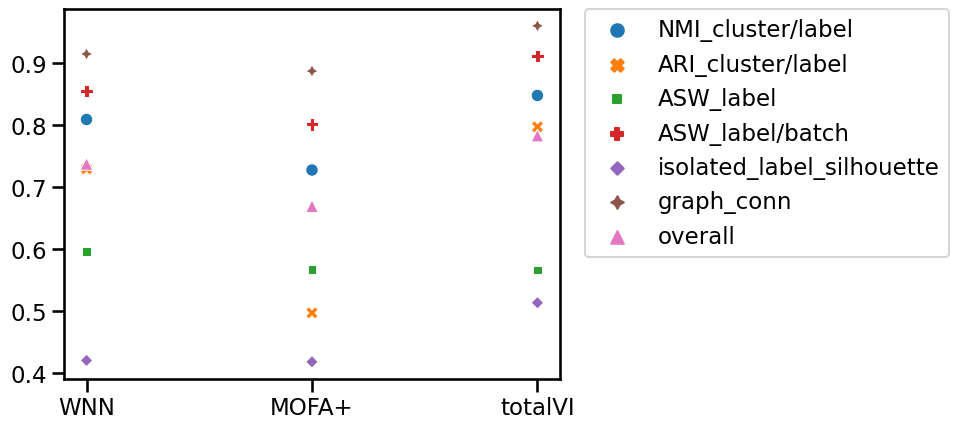

In [53]:
sns.scatterplot(data=metrics)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

We observe that totalVI obtained the highest overall score, and therefore we will use totalVI embedding later in the notebook to show how one can annotate the cluster in the latent space using both ADT and RNA markers. Depending on the downstream task and the experimental design, selecting the best performing based on a specific metric is advisable.

## Multiome data
To show that integration methods can also work with multiome (i.e. paired RNA-seq and ATAC-seq) data, we demonstrate how multiVI can be used for this task. We note that WNN and MOFA+ can also be run on multiome data with almost exactly the same code as above, so here we only present multiVI where the underlying model differs from totalVI.

### Prepare data

In [54]:
atac = sc.read(
    "/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/neurips-multiome/atac_hvf.h5ad"
)
atac

AnnData object with n_obs × n_vars = 69249 × 40002
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'cell_type_l2', 'cell_type_l1', 'cell_type_l3', 'assay'
    var: 'feature_types', 'gene_id', 'n_cells', 'prop_shared_cells', 'variability_score'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'binary', 'counts', 'cpm', 'tf-idf', 'tf-idf-binary', 'tf-idf-counts'

In [55]:
rna = sc.read(
    "/lustre/groups/ml01/workspace/anastasia.litinetskaya/data/neurips-multiome/rna_hvg.h5ad"
)
rna

AnnData object with n_obs × n_vars = 69249 × 4000
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ATAC_gene_activity_var_names', 'Site_colors', 'batch_colors', 'cell_type_colors', 'dataset_id', 'genome', 'hvg', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_umap'
    layers: 'counts'

We again subset the data to one site and 3 batches.

In [56]:
batches_to_keep = ["s1d1", "s1d2", "s1d3"]
rna = rna[rna.obs["batch"].isin(batches_to_keep)]
atac = atac[atac.obs["batch"].isin(batches_to_keep)]

In [57]:
mdata_multiome = mu.MuData({"rna": rna, "atac": atac})
mdata_multiome

MuData object with n_obs × n_vars = 17243 × 44002
  var:	'feature_types', 'gene_id'
  2 modalities
    rna:	17243 x 4000
      obs:	'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
      var:	'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'ATAC_gene_activity_var_names', 'Site_colors', 'batch_colors', 'cell_type_colors', 'dataset_id', 'genome', 'hvg', 'organism'
      obsm:	'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap', 'X_umap'
      layers:	'counts'
    atac:	17243 x 40002
      obs:	'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'cell_type_l2', 'cell_type_l1', 'cell_type_l3', 'assay'
      var:	'feature_types', 'gene_id', 'n_cells', 'prop_shared_cells', 'variability_score'
      uns:	'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
      obsm:	'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
      layers:	'binary', 'counts', 'cpm', 'tf-idf', 'tf-idf-binary', 'tf-idf-counts'

In [58]:
mdata_multiome.obs["batch"] = mdata_multiome["rna"].obs["batch"].copy()
mdata_multiome.obs["cell_type"] = mdata_multiome["rna"].obs["cell_type"].copy()

### MultiVI

MultiVI is also based on variational inference and conditional variational autoencoders. The gene expression counts are modeled exactly the same way as in totalVI, i.e. using raw counts and NB distribution. Chromatin accessibility on the other hand is modeled using Bernoulli distribution modeling how likely a particular region is to be open. Hence, the input data for ATAC assay has to be binary where 0 means a closed region and 1 means an open region.

In [59]:
n_genes = len(rna.var_names)
n_regions = len(atac.var_names)

MultiVI requires one AnnData object with concatenated genes and peaks as features. Since we start off with two different objects for each modality but have paired measurements, we can use the following trick to concatenate the AnnData objects along the feature axis.

In [60]:
adata_paired = ad.concat([rna.copy().T, atac.copy().T]).T
adata_paired.obs = adata_paired.obs.join(rna.obs[["cell_type", "batch"]])
adata_paired.obs["modality"] = "paired"
adata_paired

AnnData object with n_obs × n_vars = 17243 × 44002
    obs: 'cell_type', 'batch', 'modality'
    var: 'feature_types', 'gene_id'
    layers: 'counts'

In [61]:
adata_mvi = scvi.data.organize_multiome_anndatas(adata_paired)

We also make sure that we pass raw counts as input to the model by specifying `layer='counts'` in the `setup_anndata` function.

In [62]:
scvi.model.MULTIVI.setup_anndata(
    adata_mvi,
    batch_key="modality",
    categorical_covariate_keys=["batch"],
    layer="counts",
)

We initialize the MultiVI model.

In [63]:
mvi = scvi.model.MULTIVI(
    adata_mvi,
    n_genes=n_genes,
    n_regions=n_regions,
)

Next, we train the model with the default parameters.

In [64]:
mvi.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/paired_integration_chapter/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:267: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 106/500:  21%|██        | 106/500 [11:30<42:46,  6.51s/it, loss=4.47e+03, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 9223.312. Signaling Trainer to stop.


Finally, we visualize the latent embedding on the UMAP.

In [65]:
mdata_multiome.obsm["X_multiVI"] = mvi.get_latent_representation()

In [66]:
sc.pp.neighbors(mdata_multiome, use_rep="X_multiVI")
sc.tl.umap(mdata_multiome)

In [67]:
mdata_multiome.obsm["X_umap_multiVI"] = mdata_multiome.obsm["X_umap"].copy()

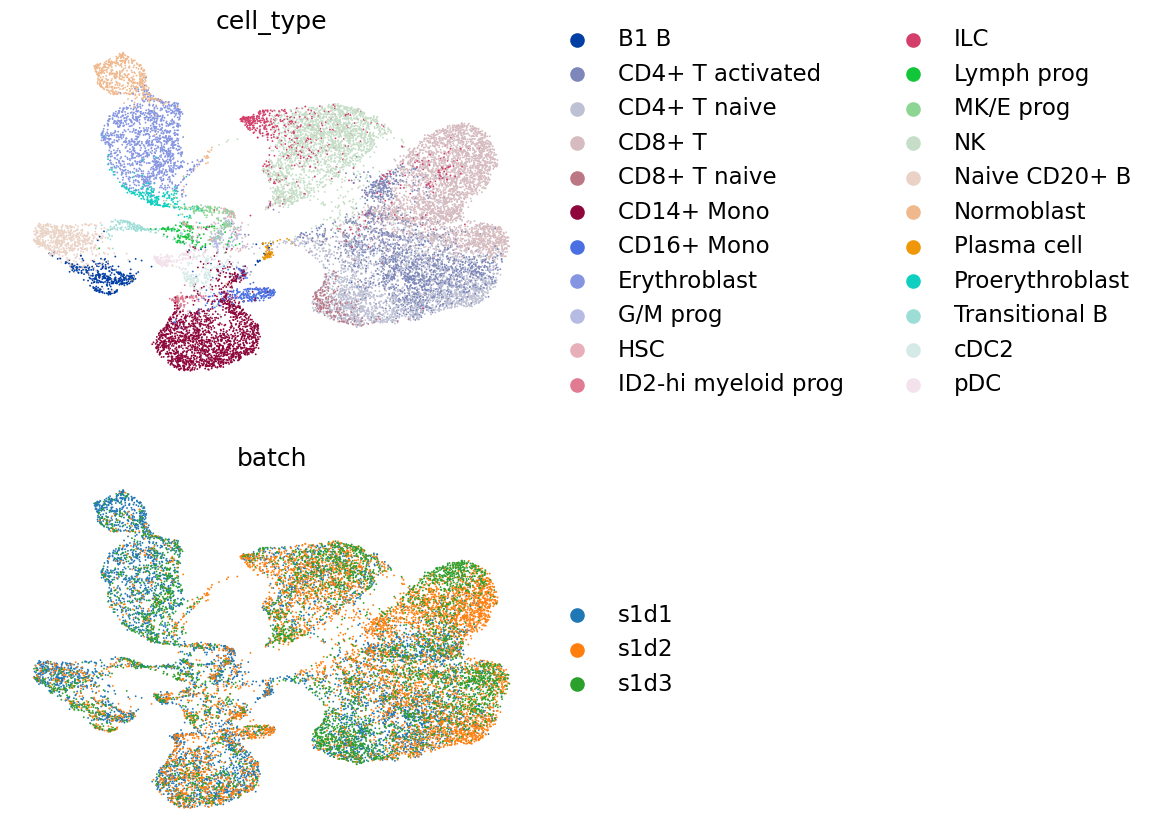

In [68]:
mu.pl.embedding(
    mdata_multiome,
    color=["cell_type", "batch"],
    ncols=1,
    basis="umap_multiVI",
    frameon=False,
)

Session info.

In [69]:
%%R
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/paired_integration_chapter/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C                 LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] Matrix_1.5-3                SingleCellExperiment_1.20.0
 [3] SummarizedExperiment_1.28.0 Biobase_2.58.0             
 [5] GenomicRanges_1.50.0        GenomeInfoDb_1.34.1        
 [7] IRanges_2.32.0              M

## References

```{bibliography}
:filter: docname in docnames
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Anastasia Litinetskaya

### Reviewers

* Lukas Heumos